# Long Term Open Source Metric Analysis

# Eclipse Swt Module Analysis

In [25]:
swt_versions = ["2.1", "3.0", "3.1","3.2", "3.3", "3.4","3.5", "3.6","3.7","3.8","4.2","4.3","4.4","4.5",
                  "4.6","4.7","4.8", "4.9"
            ]


neededColumnsClass =['cbo','cboModified','fanin','fanout','wmc','rfc','loc'
                      #,'loopQty','returnsQty','variablesQty','parametersQty','methodsInvokedQty',
                      #'methodsInvokedLocalQty','methodsInvokedIndirectLocalQty',
                      #'comparisonsQty','tryCatchQty','parenthesizedExpsQty',
                      #'stringLiteralsQty','numbersQty','assignmentsQty','mathOperationsQty',
                      #'maxNestedBlocksQty','anonymousClassesQty','innerClassesQty',
                      #'lambdasQty','uniqueWordsQty','modifiers','logStatementsQty'
               ]


In [26]:
import pandas as pd

classCkMetricsAllVersionsDf = pd.read_csv('DataSource/swt_AllCkMetricsAllVersionsMethod.csv')

In [27]:
swt_bugsDf = pd.read_csv('DataSource/swt_bugs_all.csv')

In [28]:
cleanedCkMetricsAllVersionsDf = (classCkMetricsAllVersionsDf
    .loc[~classCkMetricsAllVersionsDf['class'].str.contains("Test")]
    .loc[~classCkMetricsAllVersionsDf['class'].str.contains("test")]
    .loc[~classCkMetricsAllVersionsDf['class'].str.contains("TEST")]
    .loc[~classCkMetricsAllVersionsDf['file'].str.contains("src/test/")]
) 

In [29]:
print("Filtered class count:", cleanedCkMetricsAllVersionsDf.shape[0])
print("Versioned bug count:", swt_bugsDf['Summary'].count())
cleanedCkMetricsAllVersionsDf.info()
swt_bugsDf.info()

Filtered class count: 179559
Versioned bug count: 8444
<class 'pandas.core.frame.DataFrame'>
Index: 179559 entries, 0 to 179558
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      179559 non-null  int64  
 1   Version                         179559 non-null  float64
 2   file                            179559 non-null  object 
 3   class                           179559 non-null  object 
 4   method                          179559 non-null  object 
 5   constructor                     179559 non-null  bool   
 6   line                            179559 non-null  int64  
 7   cbo                             179559 non-null  int64  
 8   cboModified                     179559 non-null  int64  
 9   fanin                           179559 non-null  int64  
 10  fanout                          179559 non-null  int64  
 11  wmc                         

In [30]:
meanCkGroupedVersions = cleanedCkMetricsAllVersionsDf.groupby("Version", as_index=False)[neededColumnsClass].mean()
stdCkGroupedVersions = cleanedCkMetricsAllVersionsDf.groupby("Version", as_index=False)[neededColumnsClass].std()
maxCkGroupedVersions = cleanedCkMetricsAllVersionsDf.groupby("Version", as_index=False)[neededColumnsClass].max()


In [31]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

swt_bugsGroupedDf= swt_bugsDf[swt_bugsDf['Version'].isin(swt_versions)].groupby("Version",
                                                                                as_index=False).count().rename(columns = {'Bug ID': 'Bug Count'})[['Version','Bug Count']]
swt_bugsGroupedDf['Version'] = swt_bugsGroupedDf['Version'].astype(float)

df = pd.merge(cleanedCkMetricsAllVersionsDf, swt_bugsGroupedDf, on="Version", how='inner')
df.columns = df.columns.str.upper()
df = df[['CBO', 'CBOMODIFIED', 'FANIN', 'FANOUT', 'WMC', 'RFC', 'LOC', 'VERSION','BUG COUNT' ]].dropna()


rows, columns = df.shape
print(f"Satır sayısı: {rows}, Sütun sayısı: {columns}")

lr= LinearRegression()

X = df[['CBO', 'CBOMODIFIED', 'FANIN', 'FANOUT', 'WMC', 'RFC', 'LOC', 'VERSION' ]]
y = df['BUG COUNT']

print(X.shape)
print(y.shape)

Y = y.values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state=100)
print("X_train boyutu", x_train.shape)
print("x_test boyutu", x_test.shape)
print("y_train boyutu", y_train.shape)
print("y_test boyutu", y_test.shape)

lr.fit(x_train, y_train)

katsayılar = pd.DataFrame(lr.coef_, columns = 
                          ['CBO', 'CBOMODIFIED', 'FANIN', 'FANOUT', 'WMC', 'RFC', 'LOC', 'VERSION' ])

katsayılar

y_pred = lr.predict(x_test)



import statsmodels.api as sm


X_train_ols = sm.add_constant(x_train)

sm_model = sm.OLS(y_train, X_train_ols)

sonuc = sm_model.fit()

print(sonuc.summary())

Satır sayısı: 179559, Sütun sayısı: 9
(179559, 8)
(179559,)
X_train boyutu (125691, 8)
x_test boyutu (53868, 8)
y_train boyutu (125691, 1)
y_test boyutu (53868, 1)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                 2.515e+04
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        14:33:50   Log-Likelihood:            -8.1006e+05
No. Observations:              125691   AIC:                         1.620e+06
Df Residuals:                  125682   BIC:                         1.620e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t  

In [47]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


swt_bugsGroupedDf= swt_bugsDf[swt_bugsDf['Version'].isin(swt_versions)].groupby("Version",
                                                                                as_index=False).count().rename(columns = {'Bug ID': 'Bug Count'})[['Version','Bug Count']]

swt_bugsGroupedDf.columns = swt_bugsGroupedDf.columns.str.upper()
maxCkGroupedVersions.columns = maxCkGroupedVersions.columns.str.upper()
swt_bugsGroupedDf['VERSION'] = swt_bugsGroupedDf['VERSION'].astype(float)
stdCkGroupedVersions.info()
print(swt_bugsGroupedDf)


df = pd.merge(maxCkGroupedVersions, swt_bugsGroupedDf, on='VERSION', how='inner')
df.columns = df.columns.str.upper()



df = df[['CBO', 'CBOMODIFIED', 'FANIN', 'FANOUT', 'WMC', 'RFC', 'LOC', 'VERSION','BUG COUNT' ]]


rows, columns = df.shape
print(f"Satır sayısı: {rows}, Sütun sayısı: {columns}")

lr= LinearRegression()

X = df[['CBO', 'CBOMODIFIED', 'FANIN', 'FANOUT', 'WMC', 'RFC', 'LOC', 'VERSION' ]]
y = df['BUG COUNT']


Y = y.values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.30, random_state=100)
print("X_train boyutu", x_train.shape)
print("x_test boyutu", x_test.shape)
print("y_train boyutu", y_train.shape)
print("y_test boyutu", y_test.shape)



import statsmodels.api as sm


X_train_ols = sm.add_constant(x_train)

sm_model = sm.OLS(y_train, X_train_ols)

sonuc = sm_model.fit()

print(sonuc.summary())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   VERSION      18 non-null     float64
 1   CBO          18 non-null     float64
 2   CBOMODIFIED  18 non-null     float64
 3   FANIN        18 non-null     float64
 4   FANOUT       18 non-null     float64
 5   WMC          18 non-null     float64
 6   RFC          18 non-null     float64
 7   LOC          18 non-null     float64
dtypes: float64(8)
memory usage: 1.3 KB
    VERSION  BUG COUNT
0       2.1        559
1       3.0       1007
2       3.1        760
3       3.2        572
4       3.3        498
5       3.4        539
6       3.5        689
7       3.6        293
8       3.7        156
9       3.8        108
10      4.2        168
11      4.3        145
12      4.4        153
13      4.5        194
14      4.6        196
15      4.7        149
16      4.8         73
17      4.9         24
S

/Users/ayferuckan/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
""""
print (y_test)
print (y_pred)

#Çizdir
indexler = range(1,2940)
#Gerçek değer
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(indexler, y_test, label = 'Gerçek Değer', color = 'red', linewidth=2)

#Gerçek değer
ax.plot(indexler, y_pred, label ='Tahmin', color='green', linewidth=2)

plt.title('GERÇEK - TAHMİN', fontsize='x-large')
plt.xlabel('Veri', fontsize='x-large')
plt.legend(loc='upper left', fontsize='x-large')
plt.ylabel('Hata Sayısı', fontsize='x-large')
plt.legend(loc='upper left')
plt.legend(fontsize='x-large')  # Büyük boyutta legend
plt.show()


#Hata Analizi
indexler = range(1,53869)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(indexler, y_test - y_pred, label = 'Residuals', color ='red', linewidth=2)

#ax.plot(indexler, np.zeros(15), color='black')

plt.title('HATALAR (RESIDUALS)', fontsize='x-large')
plt.xlabel('Veri', fontsize='x-large')
plt.ylabel('Hata Sayısı', fontsize='x-large')
plt.legend(fontsize='x-large')  # Büyük boyutta legend
plt.show()


# Means Squared Error Hesaplama

r_2 = r2_score(y_test, y_pred)

print(r_2 *100)

""""

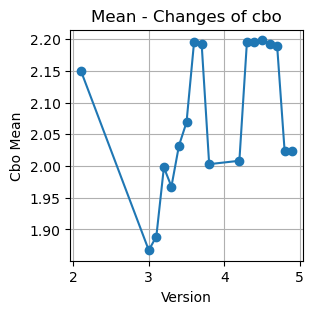

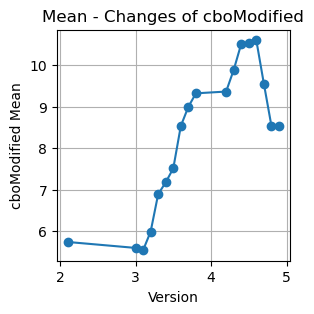

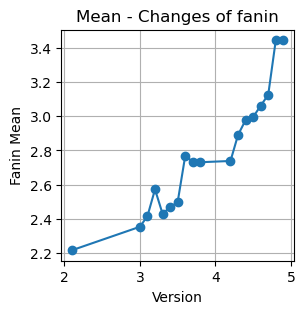

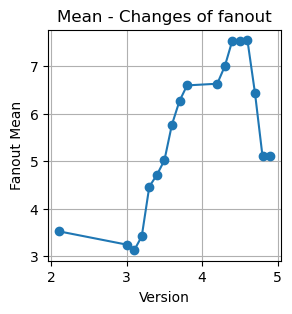

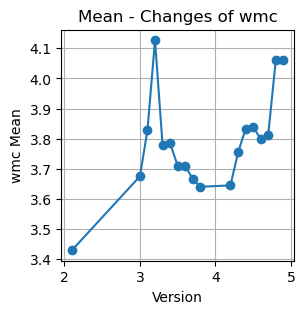

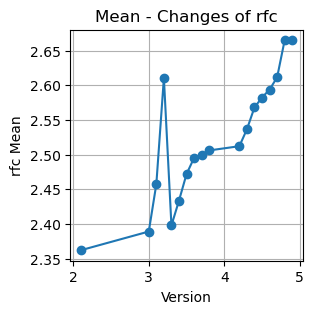

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['cbo'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Cbo Mean')
plt.title('Mean - Changes of cbo')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['cboModified'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('cboModified Mean')
plt.title('Mean - Changes of cboModified')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['fanin'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Fanin Mean')
plt.title('Mean - Changes of fanin')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['fanout'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Fanout Mean')
plt.title('Mean - Changes of fanout')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['wmc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('wmc Mean')
plt.title('Mean - Changes of wmc')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(meanCkGroupedVersions['Version'], meanCkGroupedVersions['rfc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('rfc Mean')
plt.title('Mean - Changes of rfc')
plt.grid(True)
plt.show()


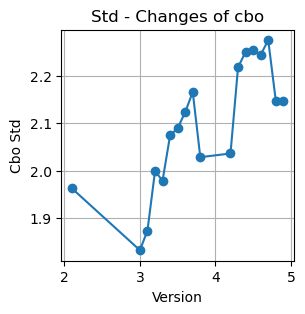

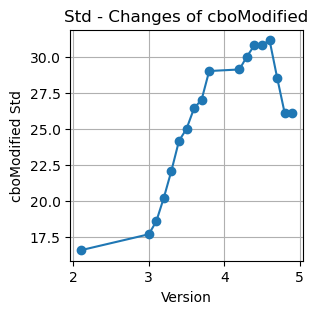

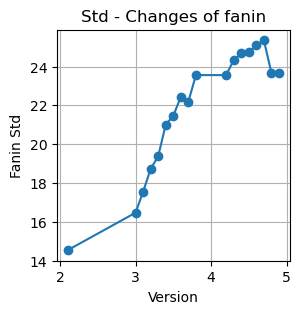

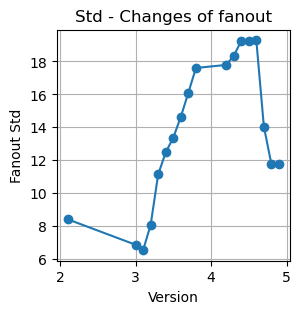

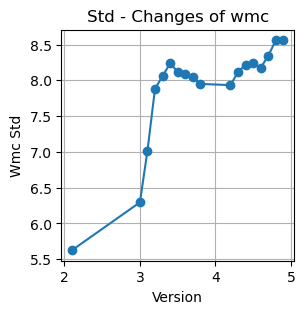

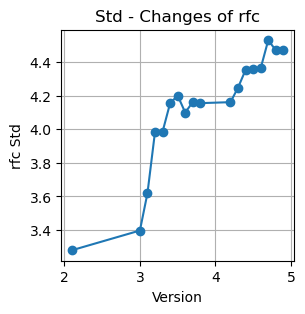

In [29]:
plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['cbo'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Cbo Std')
plt.title('Std - Changes of cbo')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['cboModified'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('cboModified Std')
plt.title('Std - Changes of cboModified')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['fanin'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Fanin Std')
plt.title('Std - Changes of fanin')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['fanout'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Fanout Std')
plt.title('Std - Changes of fanout')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['wmc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Wmc Std')
plt.title('Std - Changes of wmc')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(stdCkGroupedVersions['Version'], stdCkGroupedVersions['rfc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('rfc Std')
plt.title('Std - Changes of rfc')
plt.grid(True)
plt.show()

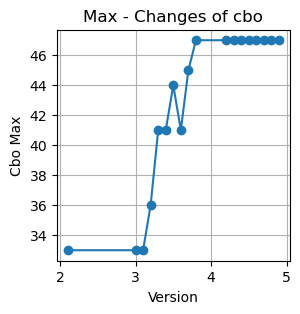

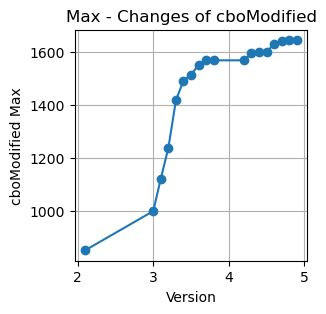

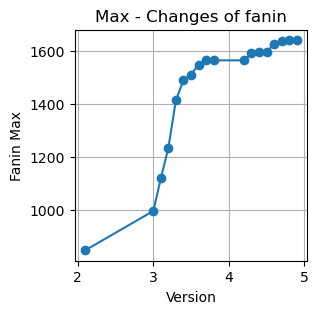

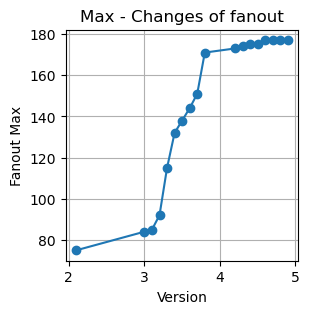

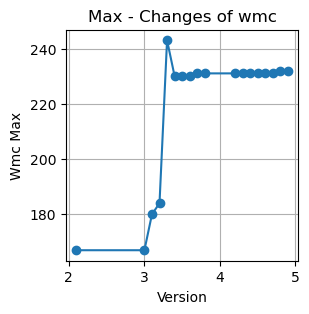

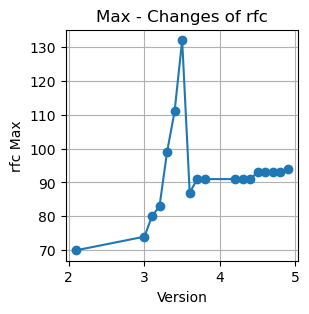

In [30]:
plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['cbo'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Cbo Max')
plt.title('Max - Changes of cbo')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['cboModified'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('cboModified Max')
plt.title('Max - Changes of cboModified')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['fanin'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Fanin Max')
plt.title('Max - Changes of fanin')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['fanout'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Fanout Max')
plt.title('Max - Changes of fanout')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['wmc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('Wmc Max')
plt.title('Max - Changes of wmc')
plt.grid(True)
plt.show()

plt.figure(figsize=(3, 3)) 
plt.plot(maxCkGroupedVersions['Version'], maxCkGroupedVersions['rfc'], marker='o', linestyle='-')
plt.xlabel('Version')
plt.ylabel('rfc Max')
plt.title('Max - Changes of rfc')
plt.grid(True)
plt.show()


In [31]:

swt_bugsGroupedDf= swt_bugsDf[swt_bugsDf['Version'].isin(swt_versions)].groupby("Version", as_index=False).count().rename(columns = {'Bug ID': 'Bug Count'})[['Version','Bug Count']]
swt_bugsGroupedDf['Version'] = swt_bugsGroupedDf['Version'].astype(float)



mergedMeanCountsDf = pd.merge(meanCkGroupedVersions, swt_bugsGroupedDf, on="Version", how='inner')
mergedStdCountsDf = pd.merge(stdCkGroupedVersions, swt_bugsGroupedDf, on="Version", how='inner')
mergedMaxCountsDf = pd.merge(maxCkGroupedVersions, swt_bugsGroupedDf, on="Version", how='inner')


In [32]:
t_mergedMeanBugCountsDf = mergedMeanCountsDf.drop(columns=['Version'])
t_mergedStdBugCountsDf = mergedStdCountsDf.drop(columns=['Version'])
t_mergedMaxBugCountsDf = mergedMaxCountsDf.drop(columns=['Version'])


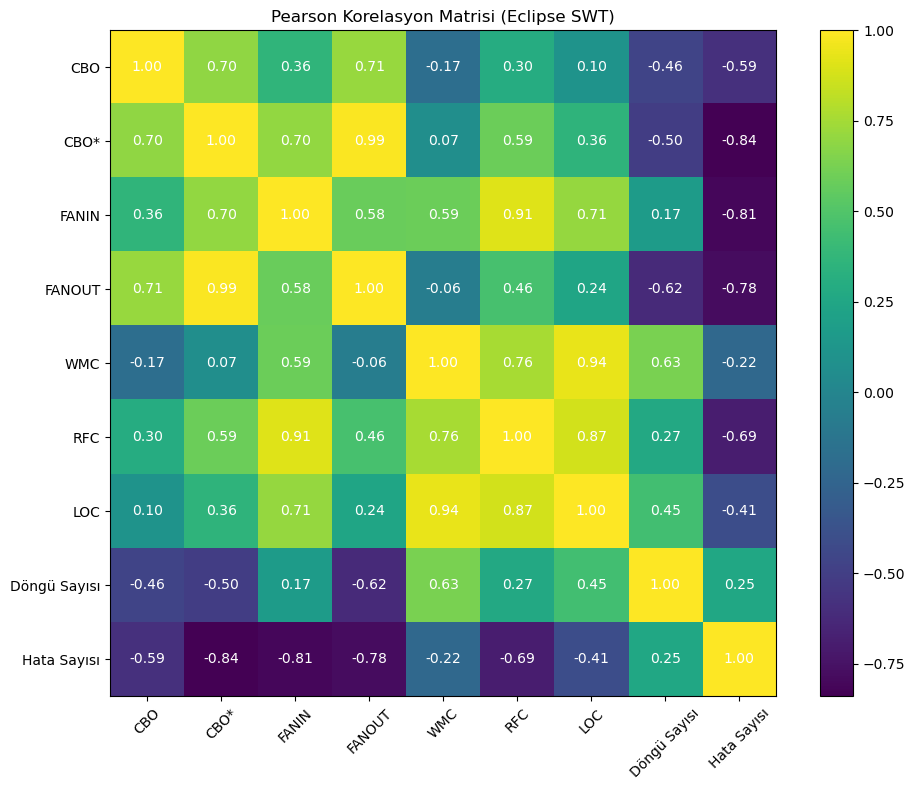

In [15]:
import numpy as np
import matplotlib.pyplot as plt

correlation_matrix = t_mergedMeanBugCountsDf.corr(method='pearson')

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')

for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='white')

plt.colorbar()
plt.title('Pearson Korelasyon Matrisi (Eclipse SWT)')
correlation_matrix.columns = ['CBO', 'CBO*', 'FANIN', 'FANOUT', 'WMC', 'RFC', 'LOC', 'Döngü Sayısı',
       'Hata Sayısı']
correlation_matrix.index = ['CBO', 'CBO*', 'FANIN', 'FANOUT', 'WMC', 'RFC', 'LOC', 'Döngü Sayısı',
       'Hata Sayısı']
plt.xticks(np.arange(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(np.arange(len(correlation_matrix)), correlation_matrix.index)
plt.tight_layout()
plt.show()


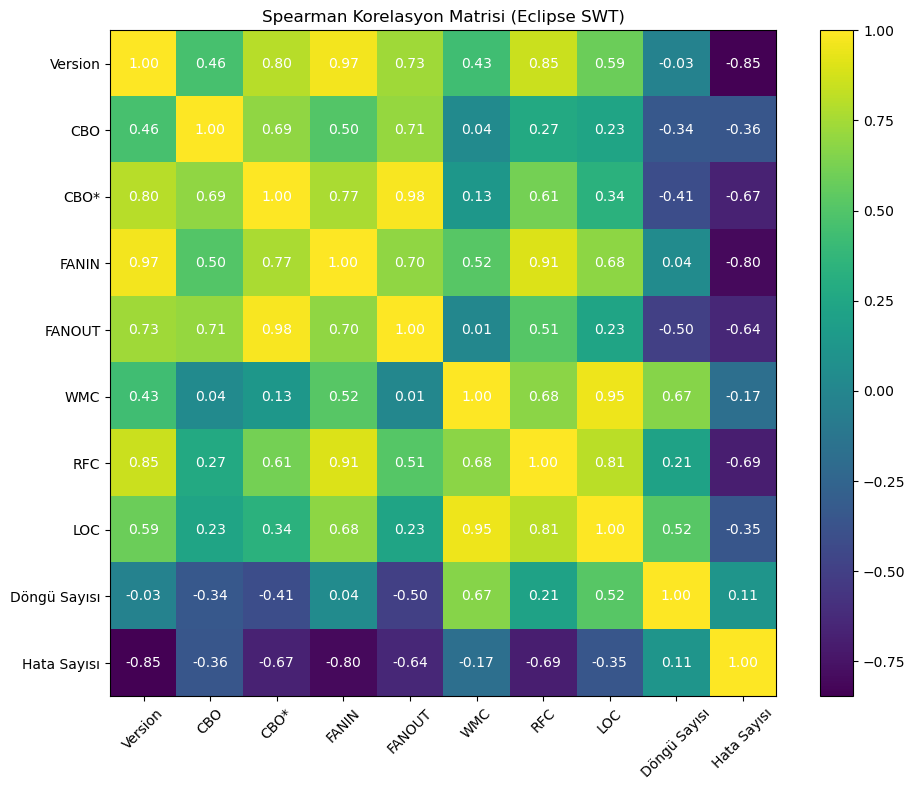

In [20]:
import numpy as np
import matplotlib.pyplot as plt

correlation_matrix = mergedMeanCountsDf.corr(method='spearman')

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')

for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='white')

plt.colorbar()
plt.title('Spearman Korelasyon Matrisi (Eclipse SWT)')
correlation_matrix.columns = ['Version','CBO', 'CBO*', 'FANIN', 'FANOUT', 'WMC', 'RFC', 'LOC', 'Döngü Sayısı',
       'Hata Sayısı']
correlation_matrix.index = ['Version','CBO', 'CBO*', 'FANIN', 'FANOUT', 'WMC', 'RFC', 'LOC', 'Döngü Sayısı',
       'Hata Sayısı']
plt.xticks(np.arange(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(np.arange(len(correlation_matrix)), correlation_matrix.index)
plt.tight_layout()
plt.show()


In [13]:
import statsmodels.api as sm


t_mergedMeanBugCountsDf = mergedMeanCountsDf.drop(columns=['Version'])
t_mergedStdBugCountsDf = mergedStdCountsDf.drop(columns=['Version'])
t_mergedMaxBugCountsDf = mergedMaxCountsDf.drop(columns=['Version'])


df = t_mergedMeanBugCountsDf;

X = df[neededColumnsClass]  # Independent variables
y = df['ExistingBug']  # Dependent variable

# Create and fit the model
model = sm.OLS(y, X).fit()

# Print the coefficients
print(model.params)


KeyError: 'ExistingBug'